In [2]:
from sklearn import svm, metrics
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None

In [6]:
def interpolateZero(dftmp, str1, str2): #str1: base point str2: interpolated value
    dftmp2=dftmp.drop(dftmp[dftmp[str2] <0].index)
    class_mean=(dftmp2[str2]-dftmp2[str1]).mean()
    class_ind=dftmp[dftmp[str2] <0].index
    val=(dftmp.loc[class_ind, [str1]]+class_mean).values
    dftmp.loc[class_ind, [str2]]=val
    return dftmp

In [7]:
df=pd.read_csv("happiness_train_complete.csv")
dftest=pd.read_csv("happiness_test_complete.csv")

def processDf(df, dfCityMean):
    year = 2015
    df["work_yr"].fillna(0,inplace=True); df["work_exper"].fillna(0,inplace=True);
    df["work_status"].fillna(0,inplace=True);df["work_type"].fillna(0,inplace=True);
    df["work_manage"].fillna(0,inplace=True); df["join_party"][df["join_party"]>=-10]=1;
    df["join_party"].fillna(0,inplace=True); df[df["happiness"] == -8]=3;
    df["income/city"] = df.apply(lambda x: x["income"]/dfCityMean.loc[[x["city"]]]["income"].values[0], axis=1)
    df["equity/city"] = df.apply(lambda x: x["equity"]/dfCityMean.loc[[x["city"]]]["equity"].values[0], axis=1)
    df["depression/city"] = df.apply(lambda x: x["depression"]/dfCityMean.loc[[x["city"]]]["depression"].values[0], axis=1)
    df["floor_area/city"] = df.apply(lambda x: x["floor_area"]/dfCityMean.loc[[x["city"]]]["floor_area"].values[0], axis=1)
    df["class/city"] = df.apply(lambda x: x["class"]/dfCityMean.loc[[x["city"]]]["class"].values[0], axis=1)
    df["BMI"] = (df["weight_jin"]/2)/(df["height_cm"]/100)**2
    df=df.loc[:, ~df.columns.isin(["survey_time","property_other", "edu_other",
                                  "invest_other", "city", "county", "province"])];
    df=df.drop(df[df["equity"] <0].index)
    df=df.drop(df[df["depression"] <0].index)
    df=df.drop(df[(df["class"]  <0)].index)
    df=interpolateZero(df, "class", "class_10_after")
    #df=df.dropna()
    df[df < 0] = np.nan;
    mean_values=round(df.mean())
    df.fillna(value=mean_values, inplace = True)
    #df.fillna(value=0, inplace = True) #Try SVM first
    df["birth"]=df["birth"].apply(lambda x: int((2015-x)/10)*10)
    df["s_birth"]=df["s_birth"].apply(lambda x: int((2015-x)/10)*10)
    df["f_birth"]=df["f_birth"].apply(lambda x: int((2015-x)/10)*10)
    df["m_birth"]=df["m_birth"].apply(lambda x: int((2015-x)/10)*10)
    df["marital_1st"]=df["marital_1st"].apply(lambda x: int((2015-x)/10)*10)
    df["marital_now"]=df["marital_now"].apply(lambda x: int((2015-x)/10)*10)
    df["edu_yr"]=df["edu_yr"].apply(lambda x: int((2015-x)/10)*10)
    df["class_10_now"] = np.where(df["class_10_after"] >df["class"], 1, 0)
    df["class_before_now"] = np.where(df["class_10_before"] >df["class"], 1, 0)
    df["inc_to_sinc"] = np.where(df["income"]>df["s_income"], 1, 0)
    return df;

def processTestDf(df, dfCityMean):
    year = 2015
    df["work_yr"].fillna(0,inplace=True); df["work_exper"].fillna(0,inplace=True);
    df["work_status"].fillna(0,inplace=True);df["work_type"].fillna(0,inplace=True);
    df["work_manage"].fillna(0,inplace=True); df["join_party"][df["join_party"]>=-10]=1;
    df["join_party"].fillna(0,inplace=True);
    df["income/city"] = df.apply(lambda x: x["income"]/dfCityMean.loc[[x["city"]]]["income"].values[0], axis=1)
    df["equity/city"] = df.apply(lambda x: x["equity"]/dfCityMean.loc[[x["city"]]]["equity"].values[0], axis=1)
    df["depression/city"] = df.apply(lambda x: x["depression"]/dfCityMean.loc[[x["city"]]]["depression"].values[0], axis=1)
    df["floor_area/city"] = df.apply(lambda x: x["floor_area"]/dfCityMean.loc[[x["city"]]]["floor_area"].values[0], axis=1)
    df["class/city"] = df.apply(lambda x: x["class"]/dfCityMean.loc[[x["city"]]]["class"].values[0], axis=1)
    df["BMI"] = (df["weight_jin"]/2)/(df["height_cm"]/100)**2
    df=df.loc[:, ~df.columns.isin(["survey_time","property_other", "edu_other",
                                  "invest_other", "city", "county", "province"])];
    df=interpolateZero(df, "class", "class_10_after")
    df[df < 0] = np.nan;
    mean_values=round(df.mean())
    df.fillna(value=mean_values, inplace = True)
    #df.fillna(value=0, inplace = True) #Try SVM first
    df["birth"]=df["birth"].apply(lambda x: int((2015-x)/10)*10)
    df["s_birth"]=df["s_birth"].apply(lambda x: int((2015-x)/10)*10)
    df["f_birth"]=df["f_birth"].apply(lambda x: int((2015-x)/10)*10)
    df["m_birth"]=df["m_birth"].apply(lambda x: int((2015-x)/10)*10)
    df["marital_1st"]=df["marital_1st"].apply(lambda x: int((2015-x)/10)*10)
    df["marital_now"]=df["marital_now"].apply(lambda x: int((2015-x)/10)*10)
    df["edu_yr"]=df["edu_yr"].apply(lambda x: int((2015-x)/10)*10)
    df["class_10_now"] = np.where(df["class_10_after"] >df["class"], 1, 0)
    df["class_before_now"] = np.where(df["class_10_before"] >df["class"], 1, 0)
    df["inc_to_sinc"] = np.where(df["income"]>df["s_income"], 1, 0)
    return df;
    
def score(y1,y2):
    total=0;
    for i in range(len(y1)):
        total+=(y1[i]-y2[i])**2
    return total/len(y1)
dftest

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 0: invalid continuation byte

In [86]:
dftmp=df[(df["income"]>=0)  & (df["equity"] >=0)&(df["depression"] >=0) &
         (df["floor_area"] >=0) & (df["class"] >=0)]
dftmp=dftmp.drop(["id", "happiness"], axis=1)
dftmp2=dftest[(dftest["income"]>=0) & (dftest["equity"] >=0) & (dftest["depression"] >=0)
                & (dftest["floor_area"] >=0)  & (dftest["class"] >=0)]
frames=[dftmp, dftmp2]
dftmp=pd.concat(frames) #~10k rows are left(test+train)
dfCityMean = dftmp.groupby(["city"]).mean()
x=dfCityMean.loc[[4]]["income"].values[0]
dfCityMean

,survey_type,province,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,id
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.0,4.703863,1.538627,1959.931330,1.038627,0.536481,1.057940,7.287554,3.732456,1587.572368,59878.489270,1.515021,1779.747126,66.448069,0.012876,0.549356,0.270386,0.184549,0.096567,0.019313,0.015021,0.025751,0.152361,166.137339,125.502146,3.538627,3.987124,4.165236,2.347639,1.619355,3.049356,2.609442,2.866953,3.944206,3.107296,2.414163,1.560086,4.055794,3.377682,2.624464,4.004292,3.630901,3.605150,3.390558,3.064378,4.401288,4.461373,2.710300,2.613734,3.180258,2.384120,4.189055,3.987562,2.038627,3.173820,5.064378,4.510730,4.364807,4.023605,3.274678,3.348259,16.820896,0.676617,2.263682,1.010730,1.068670,1.622318,1.587983,110889.175966,2.109442,2.665236,0.873391,1.813305,0.051502,0.684549,0.248927,0.055794,0.019313,0.006438,0.0,0.0,0.008584,0.523605,0.469957,0.209677,3.302575,1806.685279,1958.566038,1896.866242,7.336478,1.616352,2.386792,57050.798742,3.405660,2.919355,0.596774,1254.098712,2.607296,0.615880,2.553648,1297.008584,1.961373,0.562232,3.892704,2.169528,1.828326,3.109442,1.437768,363668.272532,3.210300,2.433476,1.770386,1.656652,3.641631,3.270386,2.364807,3.255365,2.160944,2.233906,-0.094421,2.135193,1.457082,3.130901,66.978541,63.987124,62.186695,65.212446,65.158798,66.309013,66.212446,66.701717,67.304721,9513.795918
2,1.708861,2.0,9.000000,1.594937,1963.974684,7.911392,0.329114,1.683544,3.898734,3.191176,1387.509434,15331.898734,1.139241,1667.833333,253.030380,0.025316,0.379747,0.392405,0.202532,0.101266,0.050633,0.012658,0.012658,0.025316,162.696203,115.569620,3.632911,3.784810,3.848101,1.417722,1.139241,1.518987,1.569620,1.810127,4.075949,1.797468,1.721519,1.291139,4.873418,2.848101,4.189873,4.518987,3.417722,3.075949,3.177215,3.936709,4.936709,3.886076,4.126582,3.215190,3.341772,1.708861,2.714286,3.090909,1.683544,3.164557,3.911392,3.417722,4.164557,2.860759,2.734177,3.826087,14.652174,1.347826,2.826087,1.063291,1.139241,1.835443,1.822785,46871.721519,3.670886,2.544304,1.265823,1.822785,0.050633,0.949367,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.936709,0.974684,0.333333,3.316456,1768.534247,1963.446154,1835.892308,3.830769,1.307692,1.276923,12608.261538,2.753846,3.782609,0.782609,858.594937,1.696203,1.240506,3.000000,908.911392,1.291139,0.962025,2.544304,2.354430,1.658228,2.974684,1.227848,29807.063291,4.240506,3.607595,4.063291,3.797468,4.278481,1.645570,2.911392,1.670886,3.177215,1.139241,-1.860759,-0.316456,1.658228,4.177215,73.708861,72.708861,67.303797,68.253165,64.886076,70.379747,68.822785,64.379747,65.594937,9252.7368

In [87]:
try:
    df[feature_arr].to_csv("processed_train.csv",encoding="utf-8", index=False)
    dftmp=pd.read_csv("processed_train.csv")
    class_mean=(dftmp["class_10_after"]-dftmp["class"]).mean()
except:
    print("proceed")

proceed


In [88]:
#dftmp

In [89]:
#dftmp["inc_exp_now"] = np.where(df["inc_exp"]>df["income"], 1, 0)

In [90]:
df = processDf(df, dfCityMean);
df

,id,happiness,survey_type,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,income/city,equity/city,depression/city,floor_area/city,class/city,BMI,class_10_now,class_before_now,inc_to_sinc
0,1,4,1,1,50,1.0,1.0,1.0,11.0,4.0,30,20000.0,1.0,0.0,45.0,0,1,0,0,0,0,0,0,0,176,155,3.0,2.0,5,5,2.0,4.0,2.0,5.0,5.0,4.0,3.0,1.0,4.0,3.0,1.0,2.0,3.0,4.0,1.0,4.0,5.0,4.0,1.0,2.0,4.0,3.0,3.0,3.0,2.0,3,3,3.0,3.0,1.0,1,3.0,30.0,1.0,2.0,1.0,1.0,1.0,2.0,60000.0,2.0,2.0,1.0,2.0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,3,30,50,30,6.0,1.0,5.0,40000.0,5.0,3.0,1.0,70,4.0,4.0,1.0,70,4.0,1.0,1.0,3.0,2.0,4.0,3.0,50000.0,4.0,2.0,4.0,3.0,5.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,1.0,4.0,50.0,60.0,50.0,50.0,30.0,30.0,50.0,50.0,50.0,0.412903,1.066826,1.244779,0.549444,0.671675,25.019370,0,0,0
1,2,4,2,1,20,1.0,1.0,1.0,12.0,4.0,0,20000.0,1.0,0.0,110.0,0,0,0,0,1,0,0,0,0,170,110,5.0,4.0,3,1,1.0,2.0,2.0,1.0,3.0,5.0,1.0,2.0,3.0,4.0,3.0,5.0,4.0,3.0,2.0,3.0,4.0,5.0,1.0,2.0,4.0,3.0,6.0,2.0,1.0,3,6,4.0,8.0,5.0,1,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,40000.0,3.0,4.0,1.0,2.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1,30,50,30,5.0,1.0,2.0,30979.0,3.0,3.0,1.0,40,3.0,1.0,2.0,40,3.0,1.0,2.0,1.0,1.0,4.0,2.0,50000.0,5.0,4.0,4.0,3.0,5.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,90.0,70.0,70.0,80.0,85.0,70.0,90.0,60.0,60.0,0.300971,0.890323,0.750000,0.694149,1.380000,19.031142,1,0,0
2,3,4,2,2,40,1.0,0.0,3.0,4.0,4.0,30,2000.0,1.0,0.0,120.0,0,1,1,0,0,0,0,0,0,160,122,4.0,4.0,5,1,1.0,2.0,2.0,2.0,5.0,1.0,3.0,1.0,4.0,4.0,3.0,5.0,4.0,4.0,2.0,3.0,5.0,5.0,5.0,3.0,4.0,2.0,2.0,5.0,2.0,4,5,4.0,6.0,3.0,2,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,8000.0,3.0,3.0,1.0,2.0,0,1,0,0,0,0,0,0,0,0.0,2.0,1.0,3,20,40,20,3.0,1.0,1.0,6000.0,3.0,3.0,1.0,70,1.0,1.0,2.0,70,1.0,1.0,2.0,2.0,1.0,4.0,2.0,80000.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,90.0,80.0,75.0,79.0,80.0,90.0,90.0,90.0,75.0,0.306649,1.214058,1.263298,0.994331,1.109813,23.828125,1,0,0
3,4,5,2,2,70,1.0,1.0,1.0,3.0,4.0,50,6420.0,1.0,0.0,78.0,0,0,0,1,0,0,0,0,0,163,170,4.0,4.0,4,1,2.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,2.0,4.0,5.0,4.0,5.0,1.0,1.0,5.0,5.0,5.0,2.0,4.0,4.0,1.0,6.0,1.0,4,5,5.0,7.0,2.0,4,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,12000.0,3.0,3.0,1.0,1.0,0,1,0,0,0,0,0,0,0,1.0,4.0,0.0,7,50,50,30,5.0,1.0,2.0,30979.0,3.0,3.0,1.0,70,14.0,1.0,2.0,70,1.0,1.0,2.0,2.0,1.0,3.0,2.0,10000.0,3.0,3.0,4.0,3.0,5.0,3.0,3.0,5.0,4.0,3.0,3.0,3.0,2.0,3.0,100.0,90.0,70.0,80.0,80.0,90.0,90.0,80.0,80.0,0.133791,1.244147,0.997319,0.785745,1.142506,31.992171,1,0,0
4,5,4,1,2,20,1.0,1.0,1.0,12.0,1.0,0,35361.0,2.0,0.0,70.0,0,0,0,0,1,0,0,0,0,165,110,5.0,5.0,3,2,3.0,1.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,3.0,2.0,4.0,4.0,3.0,5.0,2.0,5.0,5.0,1.0,4.0,3.0,4.0,7.0,5.0,3.0,2,1,1.0,1.0,4.0,6,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,74144.0,4.0,3.0,1.0,1.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1,

In [91]:
#'''
df0=df.loc[df["happiness"] == 0]; df1=df.loc[df["happiness"] == 1];
df2=df.loc[df["happiness"] == 2]; df3=df.loc[df["happiness"] == 3];
df4=df.loc[df["happiness"] == 4]; df5=df.loc[df["happiness"] == 5];
'''
#remove_n=df4.shape[0]-df5.shape[0]
#drop_indices = np.random.choice(df4.index, remove_n, replace=False)
#df4=df4.drop(drop_indices)
frames=[df1,df2,df3,df4,df5]
df=pd.concat(frames)
df
'''

'\n#remove_n=df4.shape[0]-df5.shape[0]\n#drop_indices = np.random.choice(df4.index, remove_n, replace=False)\n#df4=df4.drop(drop_indices)\nframes=[df1,df2,df3,df4,df5]\ndf=pd.concat(frames)\ndf\n'

In [92]:
try:
    #print("0: ", df4.shape[0]/df0.shape[0])
    print("1: ", df4.shape[0]/df1.shape[0])
    print("2: ", df4.shape[0]/df2.shape[0])
    print("3: ", df4.shape[0]/df3.shape[0])
    print("5: ", df4.shape[0]/df5.shape[0])
except ZeroDivisionError:
    print("proceed")


1:  48.60204081632653
2:  9.800411522633745
3:  4.148954703832753
5:  3.446454413892909


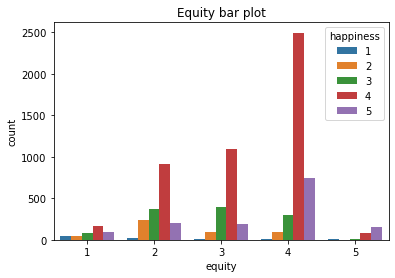

In [102]:
df_happiness_equity=df.groupby(["equity", "happiness"]).size().reset_index(name = "count")
sns.barplot(x="equity", y="count", hue="happiness", data = df_happiness_equity)
plt.title("Equity bar plot")
plt.show()
#df_happiness_equity

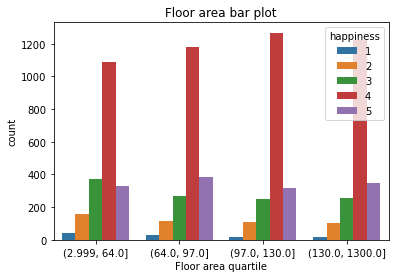

In [100]:
cat=pd.qcut(df["floor_area"].values,4)
df_happiness_equity=df[["floor_area", "happiness"]]
df_happiness_equity["Floor area quartile"] = cat
df_happiness_equity=df_happiness_equity.groupby(["Floor area quartile", "happiness"]).size().reset_index(name = "count")
sns.barplot(x="Floor area quartile", y="count", hue="happiness", data = df_happiness_equity)
plt.title("Floor area bar plot")
plt.show()

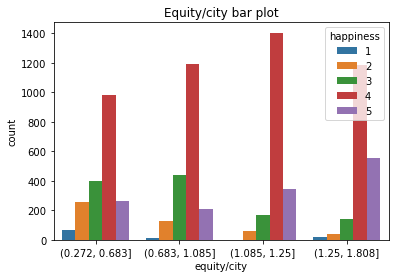

In [103]:
cat=pd.qcut(df["equity/city"].values,4)
df_happiness_equity=df[["equity/city", "happiness"]]
df_happiness_equity["equity/city"] = cat
df_happiness_equity=df_happiness_equity.groupby(["equity/city", "happiness"]).size().reset_index(name = "count")
sns.barplot(x="equity/city", y="count", hue="happiness", data = df_happiness_equity)
plt.title("Equity/city bar plot")
plt.show()

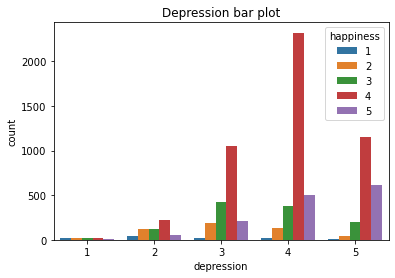

In [101]:
df_happiness_equity=df.groupby(["depression", "happiness"]).size().reset_index(name = "count")
sns.barplot(x="depression", y="count", hue="happiness", data = df_happiness_equity)
plt.title("Depression bar plot")
plt.show()

In [16]:
'''
feature_arr=np.array(['equity/city', 'depression/city', 'health', 'weight_jin',
       'class/city', 'family_status', 'equity', 'class_10_after',
       'public_service_7', 'floor_area/city', 'depression', 'inc_exp',
       'neighbor_familiarity', 'floor_area', 'family_income', 'view',
       'family_m', 'inc_ability', 'income/city', 'public_service_9',
       'public_service_6', 'leisure_9', 'height_cm', 'income',
       'social_neighbor', 'relax', 'marital_1st', 'class',
       'public_service_5', 'public_service_3', 'public_service_8',
       'birth', 'leisure_8', 'status_3_before', 'status_peer', 'class_14',
       'public_service_4', 'public_service_2', 'media_4', 'media_3',
       'public_service_1', 'trust_2', 'f_work_14', 'house',
       'class_10_before', 'trust_1', 's_income', 'health_problem',
       'leisure_1', 'edu', 'daughter', 'leisure_6', 'trust_9',
       'socialize', 'leisure_3', 'social_friend', 'marital', 'trust_12',
       'trust_4', 'trust_6', 'trust_7', 'f_edu', 'trust_5', 'work_exper',
       's_birth', 'work_yr', 'trust_13', 's_edu', 'trust_11', 'trust_8']); 
feature_arr=np.append(feature_arr,["class_10_now", "class_before_now", "inc_to_sinc"])
'''

'\nfeature_arr=np.array([\'equity/city\', \'depression/city\', \'health\', \'weight_jin\',\n       \'class/city\', \'family_status\', \'equity\', \'class_10_after\',\n       \'public_service_7\', \'floor_area/city\', \'depression\', \'inc_exp\',\n       \'neighbor_familiarity\', \'floor_area\', \'family_income\', \'view\',\n       \'family_m\', \'inc_ability\', \'income/city\', \'public_service_9\',\n       \'public_service_6\', \'leisure_9\', \'height_cm\', \'income\',\n       \'social_neighbor\', \'relax\', \'marital_1st\', \'class\',\n       \'public_service_5\', \'public_service_3\', \'public_service_8\',\n       \'birth\', \'leisure_8\', \'status_3_before\', \'status_peer\', \'class_14\',\n       \'public_service_4\', \'public_service_2\', \'media_4\', \'media_3\',\n       \'public_service_1\', \'trust_2\', \'f_work_14\', \'house\',\n       \'class_10_before\', \'trust_1\', \'s_income\', \'health_problem\',\n       \'leisure_1\', \'edu\', \'daughter\', \'leisure_6\', \'trust_9\',\

In [17]:
excl_df = df.loc[:, ~df.columns.isin(["id","happiness"])];
try:
    excl_df=excl_df[feature_arr]
except:
    print("Full feature")
excl_norm_df = (excl_df-excl_df.mean())/excl_df.std(); 
excl_norm_df.fillna(value=0, inplace = True)
excl_df

Full feature


,survey_type,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,income/city,equity/city,depression/city,floor_area/city,class/city,BMI,class_10_now,class_before_now,inc_to_sinc
0,1,1,50,1.0,1.0,1.0,11.0,4.0,30,20000.0,1.0,0.0,45.0,0,1,0,0,0,0,0,0,0,176,155,3.0,2.0,5,5,2.0,4.0,2.0,5.0,5.0,4.0,3.0,1.0,4.0,3.0,1.0,2.0,3.0,4.0,1.0,4.0,5.0,4.0,1.0,2.0,4.0,3.0,3.0,3.0,2.0,3,3,3.0,3.0,1.0,1,3.0,30.0,1.0,2.0,1.0,1.0,1.0,2.0,60000.0,2.0,2.0,1.0,2.0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,3,30,50,30,6.0,1.0,5.0,40000.0,5.0,3.0,1.0,70,4.0,4.0,1.0,70,4.0,1.0,1.0,3.0,2.0,4.0,3.0,50000.0,4.0,2.0,4.0,3.0,5.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,1.0,4.0,50.0,60.0,50.0,50.0,30.0,30.0,50.0,50.0,50.0,0.412903,1.066826,1.244779,0.549444,0.671675,25.019370,0,0,0
1,2,1,20,1.0,1.0,1.0,12.0,4.0,0,20000.0,1.0,0.0,110.0,0,0,0,0,1,0,0,0,0,170,110,5.0,4.0,3,1,1.0,2.0,2.0,1.0,3.0,5.0,1.0,2.0,3.0,4.0,3.0,5.0,4.0,3.0,2.0,3.0,4.0,5.0,1.0,2.0,4.0,3.0,6.0,2.0,1.0,3,6,4.0,8.0,5.0,1,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,40000.0,3.0,4.0,1.0,2.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1,30,50,30,5.0,1.0,2.0,30979.0,3.0,3.0,1.0,40,3.0,1.0,2.0,40,3.0,1.0,2.0,1.0,1.0,4.0,2.0,50000.0,5.0,4.0,4.0,3.0,5.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,90.0,70.0,70.0,80.0,85.0,70.0,90.0,60.0,60.0,0.300971,0.890323,0.750000,0.694149,1.380000,19.031142,1,0,0
2,2,2,40,1.0,0.0,3.0,4.0,4.0,30,2000.0,1.0,0.0,120.0,0,1,1,0,0,0,0,0,0,160,122,4.0,4.0,5,1,1.0,2.0,2.0,2.0,5.0,1.0,3.0,1.0,4.0,4.0,3.0,5.0,4.0,4.0,2.0,3.0,5.0,5.0,5.0,3.0,4.0,2.0,2.0,5.0,2.0,4,5,4.0,6.0,3.0,2,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,8000.0,3.0,3.0,1.0,2.0,0,1,0,0,0,0,0,0,0,0.0,2.0,1.0,3,20,40,20,3.0,1.0,1.0,6000.0,3.0,3.0,1.0,70,1.0,1.0,2.0,70,1.0,1.0,2.0,2.0,1.0,4.0,2.0,80000.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,90.0,80.0,75.0,79.0,80.0,90.0,90.0,90.0,75.0,0.306649,1.214058,1.263298,0.994331,1.109813,23.828125,1,0,0
3,2,2,70,1.0,1.0,1.0,3.0,4.0,50,6420.0,1.0,0.0,78.0,0,0,0,1,0,0,0,0,0,163,170,4.0,4.0,4,1,2.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,2.0,4.0,5.0,4.0,5.0,1.0,1.0,5.0,5.0,5.0,2.0,4.0,4.0,1.0,6.0,1.0,4,5,5.0,7.0,2.0,4,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,12000.0,3.0,3.0,1.0,1.0,0,1,0,0,0,0,0,0,0,1.0,4.0,0.0,7,50,50,30,5.0,1.0,2.0,30979.0,3.0,3.0,1.0,70,14.0,1.0,2.0,70,1.0,1.0,2.0,2.0,1.0,3.0,2.0,10000.0,3.0,3.0,4.0,3.0,5.0,3.0,3.0,5.0,4.0,3.0,3.0,3.0,2.0,3.0,100.0,90.0,70.0,80.0,80.0,90.0,90.0,80.0,80.0,0.133791,1.244147,0.997319,0.785745,1.142506,31.992171,1,0,0
4,1,2,20,1.0,1.0,1.0,12.0,1.0,0,35361.0,2.0,0.0,70.0,0,0,0,0,1,0,0,0,0,165,110,5.0,5.0,3,2,3.0,1.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,3.0,2.0,4.0,4.0,3.0,5.0,2.0,5.0,5.0,1.0,4.0,3.0,4.0,7.0,5.0,3.0,2,1,1.0,1.0,4.0,6,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,74144.0,4.0,3.0,1.0,1.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1,30,50,30,5.0,1.0,2.0,30979.0,3.0,

In [18]:
def genWeightCol(Yset):
    arr = np.ones((len(Yset)))
    for i in range(len(Yset)):
        if (Yset[i] == 0): arr[i]=1;
        if (Yset[i] == 1): arr[i]=1 #48.7;
        if (Yset[i] == 2): arr[i]=1 #9.8;
        if (Yset[i] == 3): arr[i]=1 #4.2;
        if (Yset[i] == 4): arr[i]=1;
        if (Yset[i] == 5): arr[i]=1 #3.45;
    return arr

In [19]:
Xset = excl_df.values;
Yset = df["happiness"].values;
Xset_norm = excl_norm_df.values;
feature_name=list(excl_df);
weight_col=genWeightCol(Yset)

In [20]:
def svmTrain(Xset, Yset):
    x_train, x_test, y_train, y_test = train_test_split(Xset, Yset, test_size = 0.3, random_state=0);
    clf = svm.SVC(
        kernel = "sigmoid",
        C = 1,
        gamma = "auto");
    
    '''
    #ee = EllipticEnvelope(contamination=0.01)
    ee = IsolationForest(contamination=0.1)
    yhat = ee.fit_predict(x_train)
    # select all rows that are not outliers
    mask = yhat != -1
    x_train, y_train= x_train[mask, :], y_train[mask]
    '''
    
    clf.fit(x_train, y_train);
    predicted = clf.predict(x_test)
    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y_test, predicted)}\n")
    disp = metrics.plot_confusion_matrix(clf, x_test, y_test, normalize="true")
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")
    plt.show()
    print("Rms: ", score(predicted, y_test))
    return clf

C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, gamma='auto', kernel='sigmoid'):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.34      0.10      0.15       163
           3       0.27      0.22      0.24       327
           4       0.64      0.91      0.75      1449
           5       0.00      0.00      0.00       400

    accuracy                           0.59      2364
   macro avg       0.25      0.25      0.23      2364
weighted avg       0.45      0.59      0.51      2364


Confusion matrix:
[[0.         0.28       0.24       0.48       0.        ]
 [0.         0.09815951 0.27607362 0.62576687 0.        ]
 [0.         0.03058104 0.22324159 0.74311927 0.0030581 ]
 [0.         0.00759144 0.084196   0.90545204 0.00276052]
 [0.         0.0075     0.065      0.9275     0.        ]]


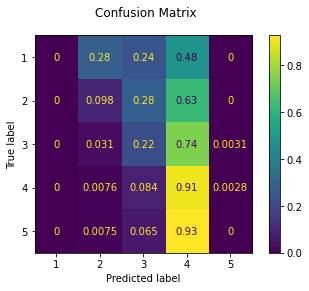

Rms:  0.6434010152284264


In [21]:
clf_svm=svmTrain(Xset_norm,Yset)

In [106]:
def lightgbmReg(Xset, Yset, feature_name, weight_col):
    x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(Xset, Yset, weight_col, test_size = 0.5, random_state=0);
    param = {
        "objective": "regression",
        "num_leaves": 20, #default: 31
        "min_data_in_leaf": 5,
        "max_depth": 5,
        "boosting": "dart",
        "learning_rate": 0.03,
        "bagging_freq" : 20,
        "bagging_fraction": 0.9,
        "max_bin": 30,
        "lambda_l2": 0.3,
        "lambda_l1": 0.1,
        "feature_fraction": 0.8,
        "metric": "regression_l2",
        "verbose": -1,
        #"n_estimators":400
    }
    
    '''
    #ee = EllipticEnvelope(contamination=0.01)
    ee = IsolationForest(contamination=0.01)
    #ee = LocalOutlierFactor(contamination=0.01)
    yhat = ee.fit_predict(x_train)
    # select all rows that are not outliers
    mask = yhat != -1
    x_train, y_train, w_train= x_train[mask, :], y_train[mask], w_train[mask]
    '''
    
    train_data = lgb.Dataset(x_train, y_train, feature_name=feature_name,
                            weight=w_train)
    train_data_eval=lgb.Dataset(x_test, y_test, weight=w_test, reference = train_data);
    clf =  lgb.train(param, train_data, num_boost_round =2329,
                                  valid_sets = train_data_eval, early_stopping_rounds=2000);

    predicted = clf.predict(x_test)
    #'''
    for i in range(len(predicted)):
        predicted[i] = int(round(predicted[i]))
        if predicted[i] >5.:
            predicted[i] =5;
    print(f"Classification report for classifier {clf}:\n"
              f"{metrics.classification_report(y_test, predicted)}\n")
    clf_matrix = metrics.confusion_matrix(y_test, predicted)
    row_sums = clf_matrix.sum(axis=1)
    norm_matrix = clf_matrix / row_sums[:, np.newaxis]
    ls=["1", "2", "3", "4", "5"]
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=norm_matrix, display_labels=ls)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal")
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    #'''
    print("Rms: ", score(predicted, y_test))
    lgb.plot_tree(clf, tree_index=0, dpi=1200, show_info = "data_percentage")
    plt.savefig("plot_tree")
    plt.show()
    lgb.plot_importance(clf, max_num_features=30, figsize=(16,9), dpi=1000)
    plt.savefig("imp")
    plt.show()
    return clf

[1]	valid_0's l2: 0.662259
[2]	valid_0's l2: 0.654234
[3]	valid_0's l2: 0.647003
[4]	valid_0's l2: 0.640043
[5]	valid_0's l2: 0.633158
[6]	valid_0's l2: 0.626637
[7]	valid_0's l2: 0.621093
[8]	valid_0's l2: 0.623328
[9]	valid_0's l2: 0.617082
[10]	valid_0's l2: 0.611286
[11]	valid_0's l2: 0.605665
[12]	valid_0's l2: 0.607578
[13]	valid_0's l2: 0.602203
[14]	valid_0's l2: 0.597213
[15]	valid_0's l2: 0.593066
[16]	valid_0's l2: 0.588338
[17]	valid_0's l2: 0.58379
[18]	valid_0's l2: 0.580233
[19]	valid_0's l2: 0.575987
[20]	valid_0's l2: 0.572037
[21]	valid_0's l2: 0.573059
[22]	valid_0's l2: 0.569041
[23]	valid_0's l2: 0.565246
[24]	valid_0's l2: 0.562036
[25]	valid_0's l2: 0.558757
[26]	valid_0's l2: 0.555986
[27]	valid_0's l2: 0.55295
[28]	valid_0's l2: 0.553986
[29]	valid_0's l2: 0.550995
[30]	valid_0's l2: 0.548331
[31]	valid_0's l2: 0.548526
[32]	valid_0's l2: 0.545894
[33]	valid_0's l2: 0.543501
[34]	valid_0's l2: 0.540814
[35]	valid_0's l2: 0.542229
[36]	valid_0's l2: 0.544238
[37

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[174]	valid_0's l2: 1.50896
[175]	valid_0's l2: 1.44794
[176]	valid_0's l2: 1.4708
[177]	valid_0's l2: 1.49635
[178]	valid_0's l2: 1.51636
[179]	valid_0's l2: 1.4551
[180]	valid_0's l2: 1.47842
[181]	valid_0's l2: 1.41954
[182]	valid_0's l2: 1.36392
[183]	valid_0's l2: 1.31147
[184]	valid_0's l2: 1.26238
[185]	valid_0's l2: 1.29673
[186]	valid_0's l2: 1.2486
[187]	valid_0's l2: 1.2035
[188]	valid_0's l2: 1.16058
[189]	valid_0's l2: 1.18354
[190]	valid_0's l2: 1.20659
[191]	valid_0's l2: 1.16368
[192]	valid_0's l2: 1.12335
[193]	valid_0's l2: 1.08554
[194]	valid_0's l2: 1.10784
[195]	valid_0's l2: 1.12805
[196]	valid_0's l2: 1.0897
[197]	valid_0's l2: 1.10498
[198]	valid_0's l2: 1.12578
[199]	valid_0's l2: 1.08759
[200]	valid_0's l2: 1.11385
[201]	valid_0's l2: 1.14002
[202]	valid_0's l2: 1.16405
[203]	valid_0's l2: 1.12401
[204]	valid_0's l2: 1.14278
[205]	valid_0's l2: 1.26832
[206]	valid_0's l2: 1.22191
[207]	valid_0's l2: 1.24354
[208]	valid_0's l2: 1.1985
[209]	valid_0's l2: 1.2233

[518]	valid_0's l2: 0.516848
[519]	valid_0's l2: 0.520027
[520]	valid_0's l2: 0.517349
[521]	valid_0's l2: 0.514746
[522]	valid_0's l2: 0.517264
[523]	valid_0's l2: 0.520467
[524]	valid_0's l2: 0.523832
[525]	valid_0's l2: 0.52729
[526]	valid_0's l2: 0.524023
[527]	valid_0's l2: 0.534938
[528]	valid_0's l2: 0.531394
[529]	valid_0's l2: 0.528269
[530]	valid_0's l2: 0.525191
[531]	valid_0's l2: 0.528612
[532]	valid_0's l2: 0.525468
[533]	valid_0's l2: 0.528647
[534]	valid_0's l2: 0.525647
[535]	valid_0's l2: 0.522479
[536]	valid_0's l2: 0.525398
[537]	valid_0's l2: 0.522403
[538]	valid_0's l2: 0.519574
[539]	valid_0's l2: 0.522665
[540]	valid_0's l2: 0.525897
[541]	valid_0's l2: 0.529654
[542]	valid_0's l2: 0.526272
[543]	valid_0's l2: 0.529409
[544]	valid_0's l2: 0.532772
[545]	valid_0's l2: 0.52909
[546]	valid_0's l2: 0.525602
[547]	valid_0's l2: 0.522585
[548]	valid_0's l2: 0.519705
[549]	valid_0's l2: 0.522708
[550]	valid_0's l2: 0.519617
[551]	valid_0's l2: 0.517024
[552]	valid_0's 

[859]	valid_0's l2: 0.499797
[860]	valid_0's l2: 0.498298
[861]	valid_0's l2: 0.496826
[862]	valid_0's l2: 0.495373
[863]	valid_0's l2: 0.496754
[864]	valid_0's l2: 0.498302
[865]	valid_0's l2: 0.496765
[866]	valid_0's l2: 0.495443
[867]	valid_0's l2: 0.494065
[868]	valid_0's l2: 0.495443
[869]	valid_0's l2: 0.494235
[870]	valid_0's l2: 0.495504
[871]	valid_0's l2: 0.496905
[872]	valid_0's l2: 0.495501
[873]	valid_0's l2: 0.496967
[874]	valid_0's l2: 0.502528
[875]	valid_0's l2: 0.504139
[876]	valid_0's l2: 0.502429
[877]	valid_0's l2: 0.503828
[878]	valid_0's l2: 0.502083
[879]	valid_0's l2: 0.503605
[880]	valid_0's l2: 0.505376
[881]	valid_0's l2: 0.50711
[882]	valid_0's l2: 0.50519
[883]	valid_0's l2: 0.506861
[884]	valid_0's l2: 0.505039
[885]	valid_0's l2: 0.503131
[886]	valid_0's l2: 0.501289
[887]	valid_0's l2: 0.499615
[888]	valid_0's l2: 0.498111
[889]	valid_0's l2: 0.499704
[890]	valid_0's l2: 0.498227
[891]	valid_0's l2: 0.496675
[892]	valid_0's l2: 0.495325
[893]	valid_0's 

[1171]	valid_0's l2: 0.504019
[1172]	valid_0's l2: 0.505311
[1173]	valid_0's l2: 0.503495
[1174]	valid_0's l2: 0.504813
[1175]	valid_0's l2: 0.50586
[1176]	valid_0's l2: 0.503979
[1177]	valid_0's l2: 0.508993
[1178]	valid_0's l2: 0.510327
[1179]	valid_0's l2: 0.508105
[1180]	valid_0's l2: 0.5093
[1181]	valid_0's l2: 0.510469
[1182]	valid_0's l2: 0.508337
[1183]	valid_0's l2: 0.506308
[1184]	valid_0's l2: 0.504413
[1185]	valid_0's l2: 0.502697
[1186]	valid_0's l2: 0.503875
[1187]	valid_0's l2: 0.502242
[1188]	valid_0's l2: 0.500656
[1189]	valid_0's l2: 0.501659
[1190]	valid_0's l2: 0.506538
[1191]	valid_0's l2: 0.507884
[1192]	valid_0's l2: 0.509318
[1193]	valid_0's l2: 0.510504
[1194]	valid_0's l2: 0.508287
[1195]	valid_0's l2: 0.506327
[1196]	valid_0's l2: 0.504408
[1197]	valid_0's l2: 0.502694
[1198]	valid_0's l2: 0.501175
[1199]	valid_0's l2: 0.502426
[1200]	valid_0's l2: 0.503602
[1201]	valid_0's l2: 0.501821
[1202]	valid_0's l2: 0.500303
[1203]	valid_0's l2: 0.498785
[1204]	valid_

[1486]	valid_0's l2: 0.489704
[1487]	valid_0's l2: 0.490291
[1488]	valid_0's l2: 0.490949
[1489]	valid_0's l2: 0.49161
[1490]	valid_0's l2: 0.492321
[1491]	valid_0's l2: 0.491603
[1492]	valid_0's l2: 0.492212
[1493]	valid_0's l2: 0.492823
[1494]	valid_0's l2: 0.493443
[1495]	valid_0's l2: 0.494187
[1496]	valid_0's l2: 0.494737
[1497]	valid_0's l2: 0.493828
[1498]	valid_0's l2: 0.492952
[1499]	valid_0's l2: 0.49357
[1500]	valid_0's l2: 0.494162
[1501]	valid_0's l2: 0.494951
[1502]	valid_0's l2: 0.495626
[1503]	valid_0's l2: 0.49634
[1504]	valid_0's l2: 0.495278
[1505]	valid_0's l2: 0.495916
[1506]	valid_0's l2: 0.496627
[1507]	valid_0's l2: 0.495554
[1508]	valid_0's l2: 0.496407
[1509]	valid_0's l2: 0.497119
[1510]	valid_0's l2: 0.497775
[1511]	valid_0's l2: 0.496585
[1512]	valid_0's l2: 0.495465
[1513]	valid_0's l2: 0.496216
[1514]	valid_0's l2: 0.496972
[1515]	valid_0's l2: 0.49761
[1516]	valid_0's l2: 0.498337
[1517]	valid_0's l2: 0.49905
[1518]	valid_0's l2: 0.497845
[1519]	valid_0'

[1799]	valid_0's l2: 0.489304
[1800]	valid_0's l2: 0.488675
[1801]	valid_0's l2: 0.488086
[1802]	valid_0's l2: 0.487679
[1803]	valid_0's l2: 0.48722
[1804]	valid_0's l2: 0.48684
[1805]	valid_0's l2: 0.486479
[1806]	valid_0's l2: 0.48612
[1807]	valid_0's l2: 0.486511
[1808]	valid_0's l2: 0.486132
[1809]	valid_0's l2: 0.486502
[1810]	valid_0's l2: 0.486086
[1811]	valid_0's l2: 0.4864
[1812]	valid_0's l2: 0.486029
[1813]	valid_0's l2: 0.485711
[1814]	valid_0's l2: 0.486029
[1815]	valid_0's l2: 0.485538
[1816]	valid_0's l2: 0.485893
[1817]	valid_0's l2: 0.485566
[1818]	valid_0's l2: 0.485241
[1819]	valid_0's l2: 0.485547
[1820]	valid_0's l2: 0.485239
[1821]	valid_0's l2: 0.485585
[1822]	valid_0's l2: 0.485998
[1823]	valid_0's l2: 0.485695
[1824]	valid_0's l2: 0.486053
[1825]	valid_0's l2: 0.486403
[1826]	valid_0's l2: 0.485979
[1827]	valid_0's l2: 0.486363
[1828]	valid_0's l2: 0.486054
[1829]	valid_0's l2: 0.486398
[1830]	valid_0's l2: 0.486721
[1831]	valid_0's l2: 0.486441
[1832]	valid_0'

[2119]	valid_0's l2: 0.484452
[2120]	valid_0's l2: 0.484108
[2121]	valid_0's l2: 0.483854
[2122]	valid_0's l2: 0.484089
[2123]	valid_0's l2: 0.485555
[2124]	valid_0's l2: 0.485888
[2125]	valid_0's l2: 0.485482
[2126]	valid_0's l2: 0.485079
[2127]	valid_0's l2: 0.485413
[2128]	valid_0's l2: 0.484985
[2129]	valid_0's l2: 0.48523
[2130]	valid_0's l2: 0.485549
[2131]	valid_0's l2: 0.485877
[2132]	valid_0's l2: 0.485443
[2133]	valid_0's l2: 0.485068
[2134]	valid_0's l2: 0.485319
[2135]	valid_0's l2: 0.485592
[2136]	valid_0's l2: 0.485903
[2137]	valid_0's l2: 0.485512
[2138]	valid_0's l2: 0.485185
[2139]	valid_0's l2: 0.484805
[2140]	valid_0's l2: 0.485107
[2141]	valid_0's l2: 0.485446
[2142]	valid_0's l2: 0.485022
[2143]	valid_0's l2: 0.484683
[2144]	valid_0's l2: 0.484969
[2145]	valid_0's l2: 0.48525
[2146]	valid_0's l2: 0.48489
[2147]	valid_0's l2: 0.485241
[2148]	valid_0's l2: 0.485492
[2149]	valid_0's l2: 0.485137
[2150]	valid_0's l2: 0.48478
[2151]	valid_0's l2: 0.485182
[2152]	valid_0

C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier <lightgbm.basic.Booster object at 0x00000265DBE0D610>:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        46
           2       0.40      0.07      0.12       260
           3       0.31      0.40      0.35       562
           4       0.68      0.87      0.76      2374
           5       0.65      0.11      0.19       697

    accuracy                           0.60      3939
   macro avg       0.41      0.29      0.28      3939
weighted avg       0.59      0.60      0.55      3939




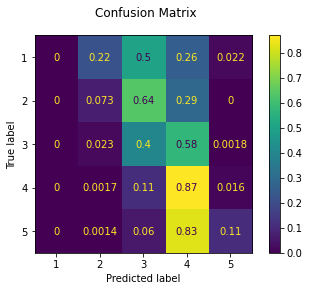

Rms:  0.5359228230515359


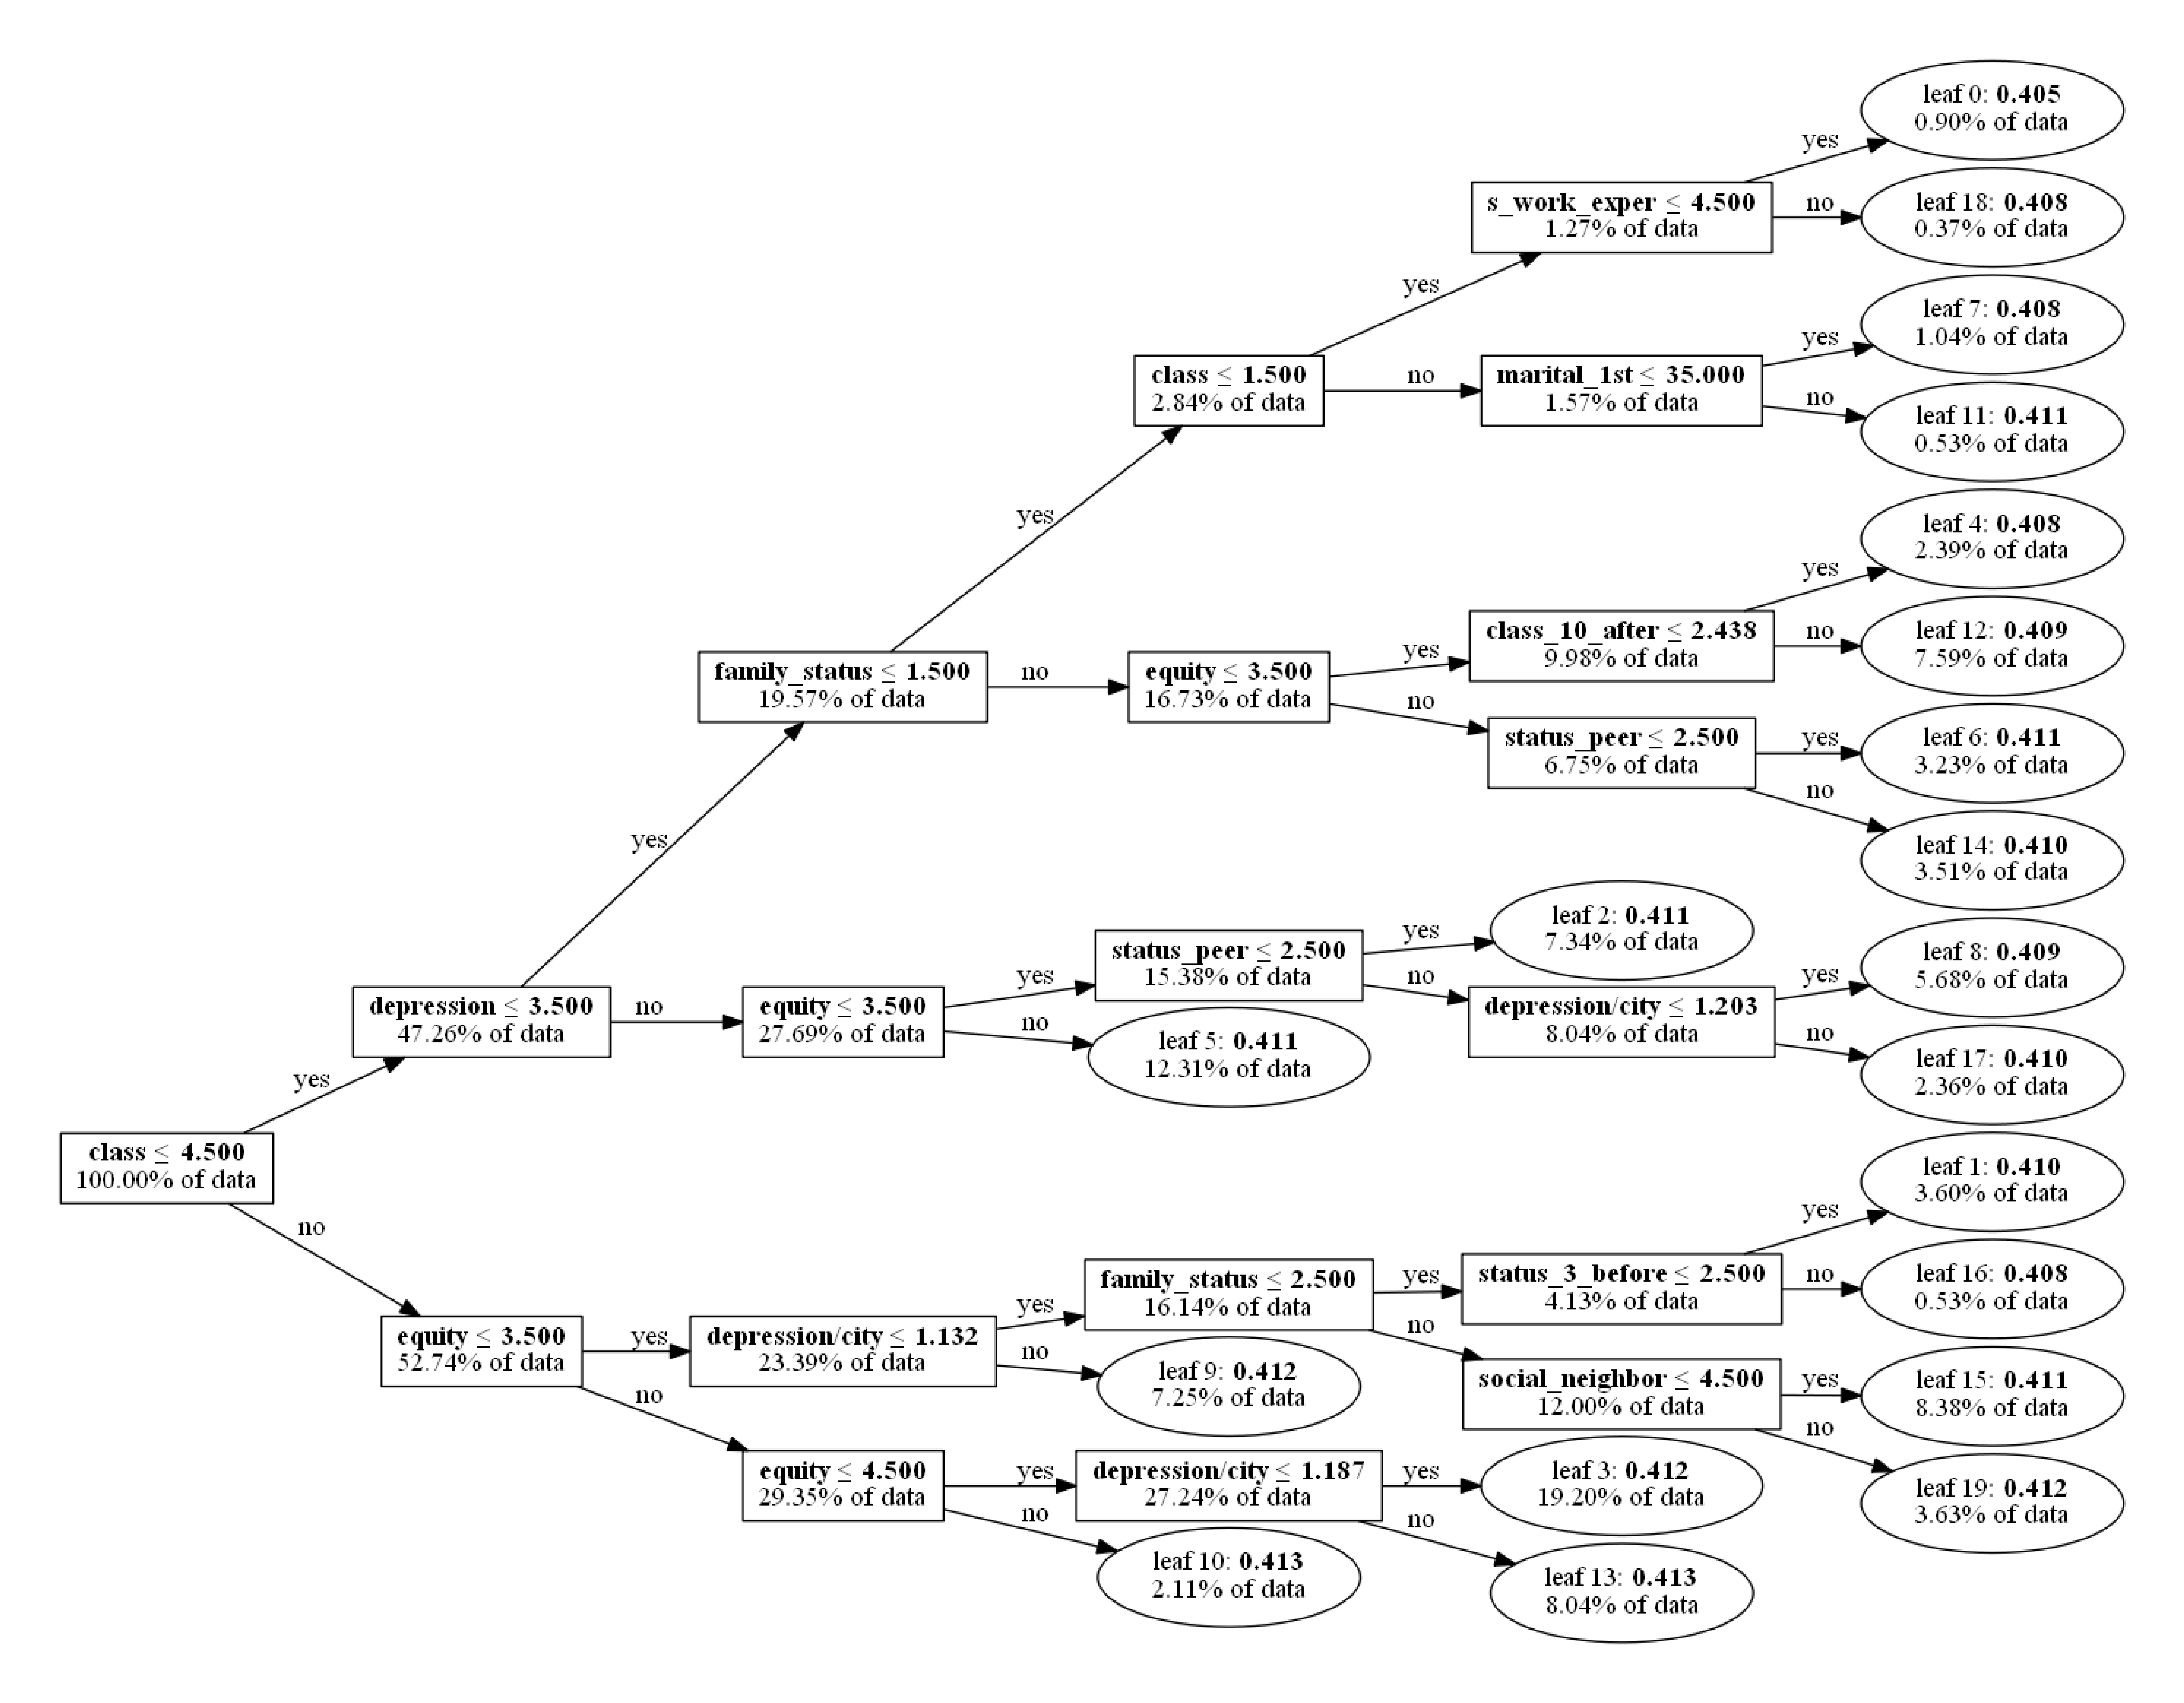

In [107]:
clf_reg=lightgbmReg(Xset, Yset, feature_name, weight_col)

In [24]:
importance = clf_reg.feature_importance(importance_type='split')
tmpname=clf_reg.feature_name()

In [25]:
feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance})
feature_importance=feature_importance.sort_values(by=["importance"], ascending=False)
feature_importance

,feature_name,importance
132,equity/city,1851
133,depression/city,1382
26,depression,967
24,health,843
53,equity,824
...,...,...
78,invest_6,0
80,invest_8,0
76,invest_4,0
77,invest_5,0


In [26]:
feature_importance.iloc[np.where(feature_importance["feature_name"]=="join_party")[0][0],1]

2

In [104]:
def lightRegSk(Xset, Yset, feature_name, weight_col):
    parameters = {
        'max_depth': [4,5],
        'num_leaves': [20,30, 40],
        "min_data_in_leaf": [1,3,5],
         "bagging_fraction": [0.7,0.8,0.9],
        "feature_fraction": [0.8,1],
        "lambda_l2": [0.3, 0.4, 0.5]
        }
    x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(Xset, Yset, weight_col, test_size = 0.3, random_state=0);
    gbm = lgb.LGBMRegressor(
        objective= "regression",
        #num_class= 6,
        num_leaves= 40, #default: 31
        min_data_in_leaf= 3,
        max_depth= 6,
        #boosting= "dart",
        learning_rate= 0.03,
        bagging_freq = 20,
        bagging_fraction= 0.8,
        max_bin= 30,
        #lambda_l2= 0.1,
        feature_fraction= 0.8,
        metric= "regression_l2",
        verbose= -1,
        n_estimators=200
    )
    
    gsearch = GridSearchCV(gbm, param_grid=parameters, 
                           scoring='neg_mean_squared_error', cv=3)
    gsearch.fit(x_train, y_train)
    print("Best Parameters:",gsearch.best_params_)
    print("Train Score:",gsearch.best_score_)
    print("Test Score:",gsearch.score(x_test,y_test))
    predicted = gsearch.predict(x_test)
    '''
    for i in range(len(predicted)):
        predicted[i] = int(round(predicted[i]))
    print(f"Classification report for classifier {gsearch}:\n"
              f"{metrics.classification_report(y_test, predicted)}\n")
    clf_matrix = metrics.confusion_matrix(y_test, predicted)
    row_sums = clf_matrix.sum(axis=1)
    norm_matrix = clf_matrix / row_sums[:, np.newaxis]
    ls=["1", "2", "3", "4", "5"]
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=norm_matrix, display_labels=ls)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal")
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    '''
    print("Rms: ", score(predicted, y_test))
    lgb.plot_tree(gsearch, tree_index=1, dpi=1200, show_info = "data_percentage")
    plt.savefig("plot_tree")
    plt.show()
    lgb.plot_importance(gsearch, max_num_features=30, figsize=(16,9), dpi=1000)
    plt.savefig("imp")
    plt.show()
    return clf

In [105]:
clf_gridsearch=lightRegSk(Xset, Yset, feature_name, weight_col)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will b

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignore

KeyboardInterrupt: 

In [31]:
name_list = feature_importance["feature_name"].values[:70]
name_list

array(['equity/city', 'depression/city', 'depression', 'health', 'equity',
       'class_10_after', 'class/city', 'family_status', 'floor_area/city',
       'BMI', 'public_service_7', 'class', 'view', 'inc_ability',
       'family_income', 'family_m', 'neighbor_familiarity',
       'public_service_9', 'weight_jin', 'inc_exp', 'floor_area',
       'public_service_6', 'house', 'leisure_9', 'height_cm',
       'income/city', 'social_neighbor', 'leisure_8', 'marital_1st',
       'public_service_5', 'public_service_3', 'status_3_before',
       'income', 'media_3', 'class_14', 'relax', 'work_yr', 'f_work_14',
       'trust_9', 'public_service_4', 'class_10_before',
       'public_service_2', 's_income', 'public_service_1',
       'public_service_8', 'status_peer', 'social_friend', 'media_4',
       'trust_1', 'daughter', 'trust_2', 'marital', 's_birth', 'birth',
       'leisure_1', 'edu', 'm_work_14', 'trust_13', 'leisure_6',
       'socia_outing', 'son', 'leisure_11', 'work_status', 'socia

Classification report for classifier AdaBoostRegressor(learning_rate=0.03, n_estimators=300, random_state=0):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.33      0.01      0.02       163
           3       0.27      0.36      0.31       327
           4       0.67      0.89      0.76      1449
           5       0.00      0.00      0.00       400

    accuracy                           0.59      2364
   macro avg       0.25      0.25      0.22      2364
weighted avg       0.47      0.59      0.51      2364




C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


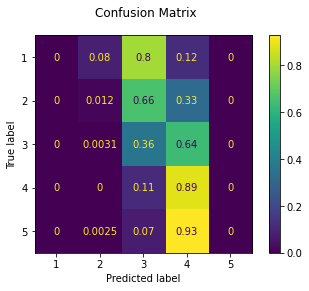

Rms:  0.5473773265651438


In [108]:
x_train, x_test, y_train, y_test = train_test_split(Xset, Yset, test_size = 0.3, random_state=0);
ada=AdaBoostRegressor(n_estimators=300, random_state=0, learning_rate=0.03)
ada.fit(x_train, y_train)
predicted = ada.predict(x_test)
#'''
for i in range(len(predicted)):
    predicted[i] = int(round(predicted[i]))
    if predicted[i] >5.:
        predicted[i] =5;
print(f"Classification report for classifier {ada}:\n"
          f"{metrics.classification_report(y_test, predicted)}\n")
clf_matrix = metrics.confusion_matrix(y_test, predicted)
row_sums = clf_matrix.sum(axis=1)
norm_matrix = clf_matrix / row_sums[:, np.newaxis]
ls=["1", "2", "3", "4", "5"]
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=norm_matrix, display_labels=ls)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal")
disp.figure_.suptitle("Confusion Matrix")
plt.show()
#'''
print("Rms: ", score(predicted, y_test))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.001,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.00100000005,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=6000, n_jobs=16,
             num_parallel_tree=1, random_state=0, reg_alpha=0.100000001,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.39      0.06      0.10       163
           3       0.29      0.33      0.31       327
           4       0.68      0.90      0.77      1449
           5       0.78      0.10      0.19 

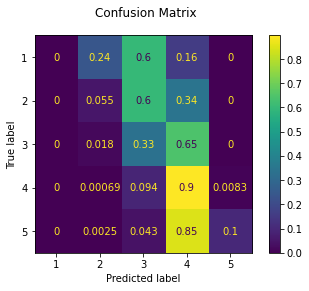

Rms:  0.5122673434856176


In [109]:
x_train, x_test, y_train, y_test = train_test_split(Xset, Yset, test_size = 0.3, random_state=0);
xgb=XGBRegressor(max_depth=6, eta=0.001, subsample=0.7, colsample_bytree=0.7, 
                 eval_metric="rmse",  n_estimators=6000,alpha=0.1)
xgb.fit(x_train, y_train)
predicted = xgb.predict(x_test)
#'''
for i in range(len(predicted)):
    predicted[i] = int(round(predicted[i]))
    if predicted[i] >5.:
        predicted[i] =5;
print(f"Classification report for classifier {xgb}:\n"
          f"{metrics.classification_report(y_test, predicted)}\n")
clf_matrix = metrics.confusion_matrix(y_test, predicted)
row_sums = clf_matrix.sum(axis=1)
norm_matrix = clf_matrix / row_sums[:, np.newaxis]
ls=["1", "2", "3", "4", "5"]
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=norm_matrix, display_labels=ls)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal")
disp.figure_.suptitle("Confusion Matrix")
plt.show()
#'''
print("Rms: ", score(predicted, y_test))

In [34]:
def lightgbmMulti(Xset, Yset, feature_name, weight_col):
    x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(Xset, Yset, weight_col, test_size = 0.4, random_state=42);
    param = {
        "objective": "multiclass",
        "num_class": 6,
        "num_leaves": 50, #default: 31
        "min_data_in_leaf": 2,
        "max_depth": 7,
        #"boosting": "dart",
        "learning_rate": 0.005,
        "bagging_freq" : 20,
        "bagging_fraction": 0.8,
        "max_bin": 50,
        #"lambda_l2": 0.1,
        "feature_fraction": 0.8,
        #"metric": "regression_l2",
        "verbose": -1
    }
    
    ee = EllipticEnvelope(contamination=0.01)
    yhat = ee.fit_predict(x_train)
    # select all rows that are not outliers
    mask = yhat != -1
    x_train, y_train, w_train= x_train[mask, :], y_train[mask], w_train[mask]
    
    train_data = lgb.Dataset(x_train, y_train, feature_name=feature_name,
                            weight=w_train)
    train_data_eval=lgb.Dataset(x_test, y_test, weight=w_test, reference = train_data);
    clf =  lgb.train(param, train_data, num_boost_round =300,
                                  valid_sets = train_data_eval,early_stopping_rounds=30);

    probability = clf.predict(x_test); predicted=np.zeros((probability.shape[0],1))
    for i in range(len(probability)):
        predicted[i] = np.argmax(probability[i])
   
    print(f"Classification report for classifier {clf}:\n"
              f"{metrics.classification_report(y_test, predicted)}\n")
    clf_matrix = metrics.confusion_matrix(y_test, predicted)
    row_sums = clf_matrix.sum(axis=1)
    norm_matrix = clf_matrix / row_sums[:, np.newaxis]
    ls=["1", "2", "3", "4", "5"]
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=norm_matrix, display_labels=ls)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal")
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    print("Rms: ", score(predicted, y_test))
    lgb.plot_tree(clf, tree_index=3, dpi=1000, show_info = "data_percentage")
    plt.savefig("plot_tree")
    plt.show()
    return clf

In [35]:
#clf_multi=lightgbmMulti(Xset, Yset, feature_name, weight_col)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(Xset, Yset, test_size = 0.5, random_state=0);
from sklearn import linear_model
ada_predicted = ada.predict(x_test)
lgb_predicted = clf_reg.predict(x_test)
xgb_predicted = xgb.predict(x_test)
X=np.vstack([lgb_predicted, xgb_predicted])
X.T

array([[3.38610717, 3.26518321],
       [3.70063709, 3.70823264],
       [4.23747612, 4.20531225],
       ...,
       [4.41419564, 4.38805628],
       [4.21990168, 4.14940405],
       [3.4295343 , 3.54517388]])

In [37]:
reg=linear_model.BayesianRidge()
reg.fit(X.T,y_test)
reg.coef_.reshape(1,2)

array([[-0.37708515,  1.58071769]])

In [38]:
X.T.shape

(3939, 2)

In [39]:
from sklearn.model_selection import KFold
fold_num=5
kf=KFold(n_splits=fold_num, random_state=0, shuffle=True)
for fold_, (trn_idx, val_idx) in enumerate(kf.split(X.T)):
    print("fold_: ", fold_)
    print("TRAIN:", trn_idx.shape, "Val:", val_idx.shape)

fold_:  0
TRAIN: (3151,) Val: (788,)
fold_:  1
TRAIN: (3151,) Val: (788,)
fold_:  2
TRAIN: (3151,) Val: (788,)
fold_:  3
TRAIN: (3151,) Val: (788,)
fold_:  4
TRAIN: (3152,) Val: (787,)


In [40]:
predicted=np.matmul(reg.coef_.reshape(1,2),X)[0]
'''
for i in range(len(predicted)):
        predicted[i] = int(round(predicted[i]))
        if predicted[i] >5.:
            predicted[i] =5;
'''
print("Rms: ", score(predicted, y_test))
predicted

Rms:  0.9600418095198497


array([3.88448213, 4.46621364, 5.04952215, ..., 5.27175056, 4.96777412,
       4.31069261])

In [41]:
y_test

array([4, 4, 4, ..., 5, 4, 4], dtype=int64)

In [72]:
dftest=pd.read_csv("happiness_test_complete.csv")
#dftest[feature_arr].to_csv("processed_test.csv", encoding="utf-8", index=False)
dftest = processTestDf(dftest, dfCityMean);

In [73]:
excl_df_test = dftest.loc[:, ~dftest.columns.isin(["id","happiness"])];
try:
    excl_df_test=excl_df_test[feature_arr]
except:
    print("Full feature")
excl_norm_df_test = (excl_df_test-excl_df_test.mean())/excl_df_test.std(); 
excl_norm_df_test.fillna(value=0, inplace = True)
excl_df_test

Full feature


,survey_type,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,income/city,equity/city,depression/city,floor_area/city,class/city,BMI,class_10_now,class_before_now,inc_to_sinc
0,1,2,40,8.0,0.0,1.0,4.0,2.0,20,18000.0,1.0,0.0,100.0,0,1,1,0,0,0,0,0,0,155,120,4.0,4.0,4.0,4,1,2,2,1,4.0,3.0,2.0,1,4.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,5.0,1.0,3.0,3,3.0,2.0,1.0,3.0,1.0,2.0,5.0,5.0,5.0,4.0,1,5.0,12.0,2.0,3.0,1.0,1.0,2.0,2.0,68538.0,5.0,3.0,1.0,2.0,0,1,0,0,0,0,0,0,0,1.0,0.0,1.0,3,10,40,10,4.0,1.0,1.0,18000.0,1.0,5.0,2.0,80,3.0,1.0,13.0,70,3.0,1.0,13.0,3.0,1.0,4.0,2.0,30000.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,4.0,80.0,80.0,60.0,80.0,80.0,80.0,80.0,80.0,80.0,1.174023,0.632000,1.039474,0.395209,1.278317,24.973985,0,0,0
1,1,2,70,1.0,1.0,1.0,4.0,4.0,20,20000.0,1.0,0.0,50.0,0,1,0,1,0,0,0,0,0,150,75,1.0,1.0,2.0,5,1,1,1,3,5.0,1.0,1.0,1,5.0,5.0,5.0,5.0,2.0,1.0,4.0,5.0,5.0,5.0,5.0,5,4.0,1.0,1.0,1.0,1.0,3.0,3.0,5.0,5.0,4.0,5,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,20000.0,1.0,1.0,2.0,2.0,0,1,0,0,0,0,0,0,0,3.0,0.0,0.0,7,50,50,20,5.0,1.0,2.0,30010.0,3.0,3.0,1.0,70,1.0,1.0,2.0,70,1.0,1.0,2.0,3.0,3.0,4.0,2.0,50000.0,3.0,3.0,3.0,3.0,4.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,90.0,80.0,80.0,80.0,80.0,80.0,70.0,80.0,80.0,0.813066,0.950276,0.543444,0.280563,0.687084,16.666667,1,1,0
2,2,2,80,1.0,1.0,1.0,1.0,4.0,20,500.0,1.0,0.0,60.0,0,0,0,1,0,0,0,0,0,155,85,4.0,2.0,2.0,1,1,1,1,1,1.0,1.0,1.0,5,5.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,2,3.0,1.0,2.0,6.0,1.0,4.0,1.0,1.0,1.0,2.0,4,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,68538.0,1.0,2.0,1.0,2.0,0,1,0,0,0,0,0,0,0,2.0,3.0,0.0,7,60,50,20,5.0,1.0,2.0,30010.0,3.0,3.0,1.0,70,1.0,1.0,2.0,100,1.0,1.0,2.0,3.0,1.0,3.0,4.0,2000.0,5.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,2.0,2.0,5.0,95.0,95.0,80.0,90.0,80.0,95.0,95.0,80.0,90.0,0.040078,1.177843,0.559557,0.456016,0.217204,17.689906,0,0,0
3,2,2,20,1.0,1.0,1.0,4.0,2.0,20,50000.0,1.0,0.0,220.0,0,0,1,0,0,0,0,0,0,160,126,5.0,5.0,5.0,1,1,2,2,1,5.0,4.0,1.0,1,5.0,4.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,2,2.0,2.0,1.0,1.0,1.0,4.0,5.0,4.0,6.0,5.0,5,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,100000.0,2.0,4.0,1.0,2.0,0,1,0,0,0,0,0,0,0,1.0,0.0,1.0,3,0,20,0,4.0,1.0,1.0,50000.0,1.0,3.0,1.0,40,4.0,1.0,2.0,40,1.0,1.0,2.0,2.0,1.0,3.0,2.0,80000.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,80.0,80.0,70.0,90.0,80.0,80.0,70.0,60.0,50.0,0.752428,1.187097,1.250000,1.388298,1.150000,24.609375,1,0,0
4,2,1,20,1.0,1.0,2.0,1.0,4.0,20,0.0,1.0,0.0,200.0,1,0,0,0,0,0,0,0,0,173,130,4.0,5.0,3.0,4,1,1,1,1,4.0,4.0,1.0,2,3.0,4.0,4.0,5.0,4.0,2.0,5.0,3.0,5.0,5.0,1.0,4,4.0,2.0,1.0,4.0,6.0,2.0,2.0,4.0,6.0,1.0,2,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,30000.0,3.0,2.0,1.0,2.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1,20,50,20,5.0,1.0,2.0,30010.0,3.0,3.0,1.0,50,3.0,1.0,2.0,70,2.0,1.0,5

In [74]:
Xset_test = excl_df_test.values;
#Yset = df["happiness"].values;
Xset_norm_test = excl_norm_df_test.values;
feature_name=list(excl_df_test);

ada_predicted = ada.predict(Xset_test)
lgb_predicted = clf_reg.predict(Xset_test)
xgb_predicted = xgb.predict(Xset_test)
X=np.vstack([lgb_predicted, xgb_predicted])

#predicted=np.matmul(reg.coef_.reshape(1,2),X)[0]
#predicted=clf_reg.predict(Xset_test)
predicted=xgb.predict(Xset_test)
#for i in range(len(predicted)):
    #predicted[i] = int(round(predicted[i]))

In [75]:
predicted

array([3.8222387, 3.1953623, 3.2359478, ..., 4.0437   , 3.9423947,
       4.809739 ], dtype=float32)

In [76]:
result=pd.DataFrame(data={"id": dftest["id"], "happiness": predicted})

In [77]:
result

,id,happiness
0,8001,3.822239
1,8002,3.195362
2,8003,3.235948
3,8004,4.359480
4,8005,3.390022
...,...,...
2963,10964,4.268533
2964,10965,3.601191
2965,10966,4.043700
2966,10967,3.942395


In [78]:
df_prev_test=pd.read_csv("test_result1.csv")

In [79]:
result["happiness"].value_counts()

4.056290    1
3.792804    1
3.658025    1
4.110545    1
3.612191    1
           ..
4.164341    1
3.768378    1
3.106943    1
3.667305    1
4.410274    1
Name: happiness, Length: 2968, dtype: int64

In [80]:
df_prev_test["happiness"].value_counts()

4.0    2450
3.0     392
5.0      94
2.0      32
Name: happiness, dtype: int64

In [81]:
df["happiness"].value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [82]:
result.to_csv("happiness_submit.csv", encoding="utf-8", index=False)

In [ ]:
df_test_on_train=pd.read_csv("happiness_train_complete.csv")
df_test_on_train = processTestDf(df_test_on_train);
excl_df_test = df_test_on_train.loc[:, ~df_test_on_train.columns.isin(["id","happiness"])];
try:
    excl_df_test=excl_df_test[feature_arr]
except:
    print("Full feature")
excl_norm_df_test = (excl_df_test-excl_df_test.mean())/excl_df_test.std(); 
excl_norm_df_test.fillna(value=0, inplace = True)
excl_df_test

In [1]:
Xset_test = excl_df_test.values;
#Yset = df["happiness"].values;
Xset_norm_test = excl_norm_df_test.values;
feature_name=list(excl_df_test);
predicted = clf_reg.predict(Xset_test)
for i in range(len(predicted)):
    predicted[i] = int(round(predicted[i]))
y_test=df_test_on_train["happiness"].values
print("Rms: ", score(predicted, y_test))

NameError: name 'excl_df_test' is not defined

In [ ]:
y_test

In [ ]:
predicted